#DATASET 1

 Loading the data and plotting the time series to check whether the data contains seasonality,trend or stationarity

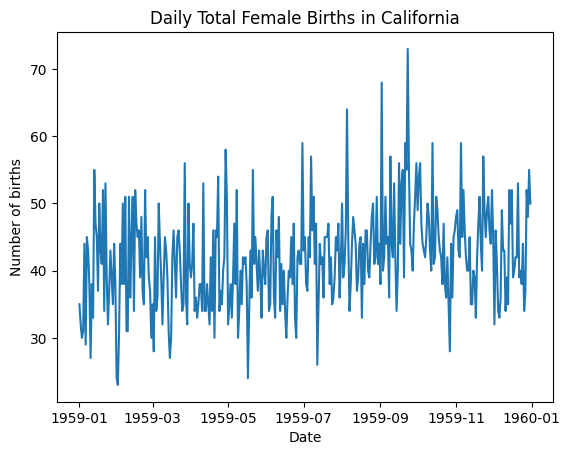

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('/content/daily-total-female-births-CA (1).csv')
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)
# Plot the time series
plt.plot(data['births'])
plt.title('Daily Total Female Births in California')
plt.xlabel('Date')
plt.ylabel('Number of births')
plt.show()

#Applying Augmented Dickey-Fuller test to test stationarity

In [ ]:
from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(data['births'])
# Output the results
print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])

ADF Statistic: -4.808291
p-value: 0.000052


# Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots to find the ARIMA parameters.

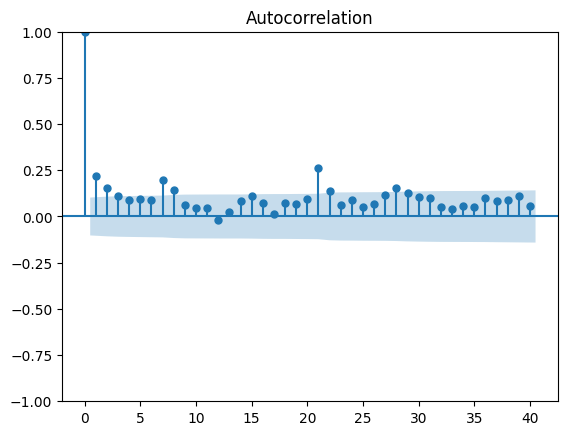

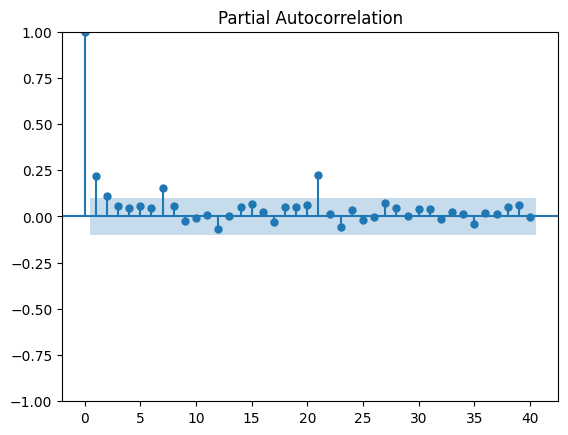

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(data['births'], lags=40)
plot_pacf(data['births'], lags=40)
plt.show()

These plots suggest that an ARIMA(1, 0, 1) model may be a good starting point.

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(data['births'], order=(1, 0, 1))
model_fit = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


#Train the model on the data and perform a forecast.

In [ ]:
forecast = model_fit.get_forecast(steps=30)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


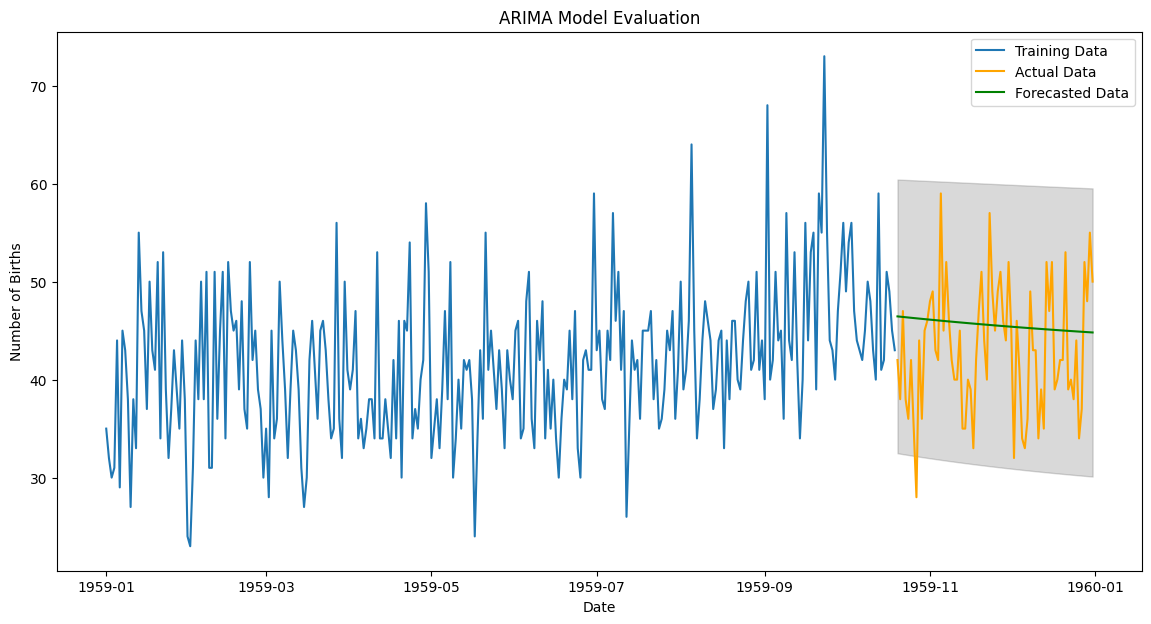

RMSE: 6.97085340106893


In [ ]:
from sklearn.metrics import mean_squared_error

# Split the data into train and test
train_size = int(len(data) * 0.8)
train, test = data[0:train_size], data[train_size:len(data)]

# Fit the ARIMA model on the training dataset
model_train = ARIMA(train['births'], order=(1, 0, 1))
model_train_fit = model_train.fit()

# Forecast on the test dataset
test_forecast = model_train_fit.get_forecast(steps=len(test))
test_forecast_series = pd.Series(test_forecast.predicted_mean, index=test.index)

# Calculate the mean squared error
mse = mean_squared_error(test['births'], test_forecast_series)
rmse = mse**0.5

# Create a plot to compare the forecast with the actual test data
plt.figure(figsize=(14,7))
plt.plot(train['births'], label='Training Data')
plt.plot(test['births'], label='Actual Data', color='orange')
plt.plot(test_forecast_series, label='Forecasted Data', color='green')
plt.fill_between(test.index,
                 test_forecast.conf_int().iloc[:, 0],
                 test_forecast.conf_int().iloc[:, 1],
                 color='k', alpha=.15)
plt.title('ARIMA Model Evaluation')
plt.xlabel('Date')
plt.ylabel('Number of Births')
plt.legend()
plt.show()

print('RMSE:', rmse)

The retrospective forecast (backtest) compares the forecasted data against the actual data in the test set. The Root Mean Squared Error (RMSE) of the forecast is approximately 6.97 births.

The plot shows the training data, the actual values from the test set (in orange), and the forecasted values (in green), with the 95% confidence interval shown as the shaded area. The model appears to capture the central tendency of the series but does not capture any potential within-sample variability, which is not surprising given that ARIMA models are often more suited for data with trends or seasonality, which this series does not appear to exhibit.

The RMSE gives an indication of the forecast accuracy, with lower values indicating better fit. Whether this level of error is acceptable depends on the specific context in which the model is being used.

#Data Set 2

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_excel('/content/Country_GDP.xlsx')
df.head()

,Time,GDP
0,1947-01-01,2034.450
1,1947-04-01,2029.024
2,1947-07-01,2024.834
3,1947-10-01,2056.508
4,1948-01-01,2087.442


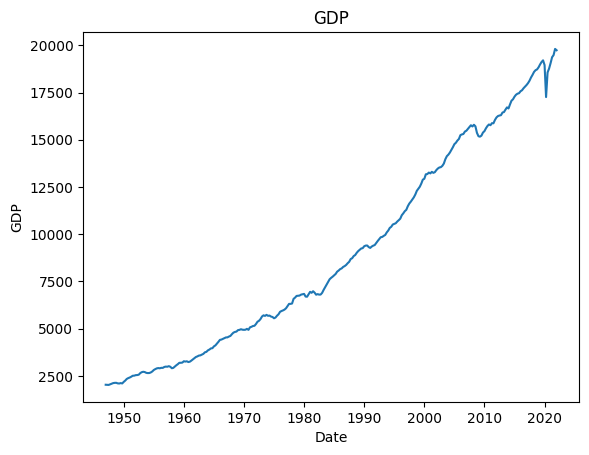

In [ ]:
df['Time'] = pd.to_datetime(df['Time'])
df.set_index('Time', inplace=True)
# Plot the time series
plt.plot(df['GDP'])
plt.title('GDP')
plt.xlabel('Date')
plt.ylabel('GDP')
plt.show()

#It is seen that there is a significant growth in the gdp over the years. A sudden drop is also seen on 2020 due to Covid

P value is much larger hence performing differencing

In [ ]:
def Augmented_Dickey_Fuller_Test_func(series , column_name):
    print (f'Results of Dickey-Fuller Test for column: {column_name}')
    dftest = adfuller(series, autolag='AIC') #AIC: Method to use when automatically determining the lag length among the values 0, 1, …, maxlag
    #The t-value measures the size of the difference relative to the variation in your sample data.
    #T is simply the calculated difference represented in units of standard error.
    #The greater the magnitude of T, the greater the evidence against the null hypothesis.

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistics','p-value','Lags Used','No. of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value #Critical values for the ADF test for 1%, 5%, and 10% significance levels with the constant model are −3.43, −2.87, and −2.57, respectively.
    print (dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion:====>")
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Conclusion:====>")
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")


Augmented_Dickey_Fuller_Test_func(df['GDP'], 'GDP')

Results of Dickey-Fuller Test for column: GDP
Test Statistics               2.634677
p-value                       0.999081
Lags Used                     1.000000
No. of Observations Used    297.000000
Critical Value (1%)          -3.452561
Critical Value (5%)          -2.871321
Critical Value (10%)         -2.571982
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is non-stationary


#Perform differencing to make the data stationary

ADF Statistic after differencing: -19.524190
p-value after differencing: 0.000000


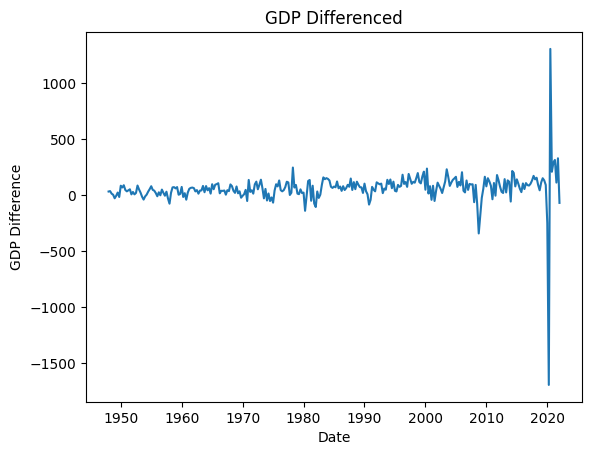

Results of Dickey-Fuller Test for column: GDP_diff
Test Statistics             -19.524190
p-value                       0.000000
Lags Used                     0.000000
No. of Observations Used    296.000000
Critical Value (1%)          -3.452637
Critical Value (5%)          -2.871354
Critical Value (10%)         -2.571999
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


In [ ]:
df['GDP_diff'] = df['GDP'].diff()
df.dropna(inplace=True)

adf_test = adfuller(df['GDP_diff'])
print('ADF Statistic after differencing: %f' % adf_test[0])
print('p-value after differencing: %f' % adf_test[1])

plt.plot(df['GDP_diff'])
plt.title('GDP Differenced')
plt.xlabel('Date')
plt.ylabel('GDP Difference')
plt.show()

Augmented_Dickey_Fuller_Test_func(df['GDP_diff'], 'GDP_diff')

#After differencing make ACF and PACF plots to find out parameters for ARIMA model

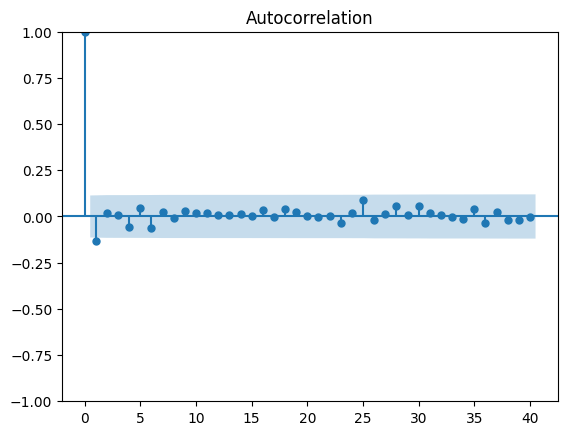

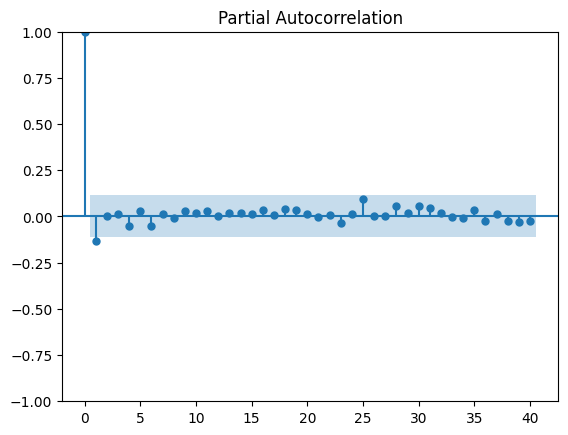

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df['GDP_diff'], lags=40)
plot_pacf(df['GDP_diff'], lags=40)
plt.show()

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(df['GDP_diff'], order=(1, 0, 1))
model_fit = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
forecast = model_fit.get_forecast(steps=30)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


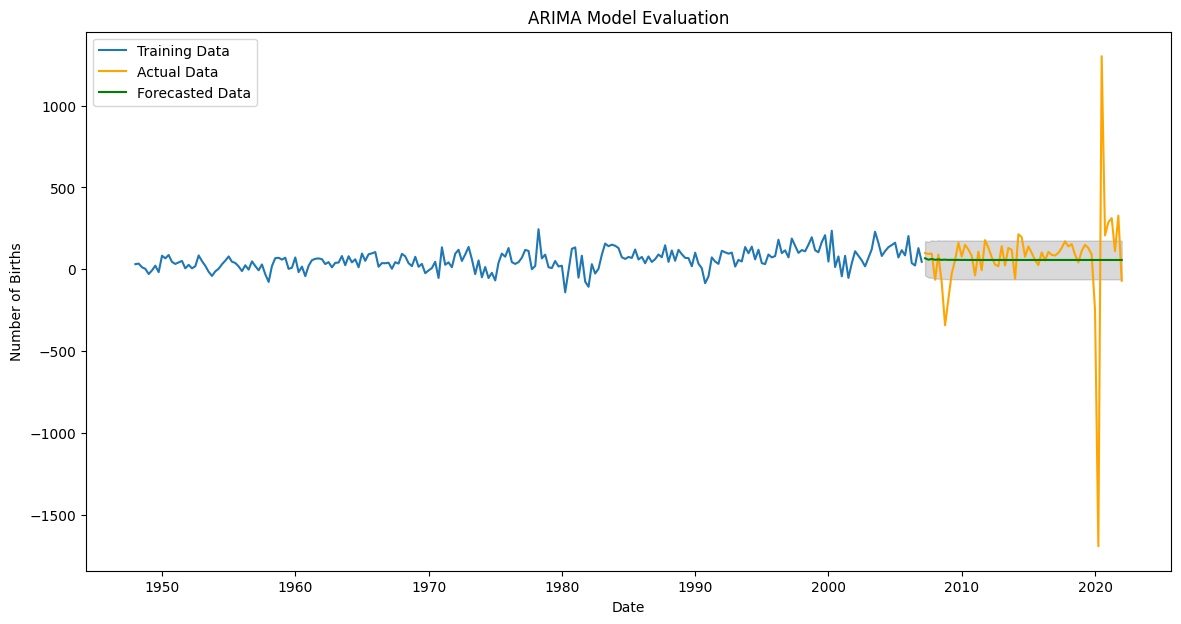

RMSE: 300.4950854169226


In [ ]:
from sklearn.metrics import mean_squared_error

# Split the data into train and test
train_size = int(len(df) * 0.8)
train, test = df[0:train_size], df[train_size:len(df)]

# Fit the ARIMA model on the training dataset
model_train = ARIMA(train['GDP_diff'], order=(2, 0, 2))
model_train_fit = model_train.fit()

# Forecast on the test dataset
test_forecast = model_train_fit.get_forecast(steps=len(test))
test_forecast_series = pd.Series(test_forecast.predicted_mean, index=test.index)

# Calculate the mean squared error
mse = mean_squared_error(test['GDP_diff'], test_forecast_series)
rmse = mse**0.5

# Create a plot to compare the forecast with the actual test data
plt.figure(figsize=(14,7))
plt.plot(train['GDP_diff'], label='Training Data')
plt.plot(test['GDP_diff'], label='Actual Data', color='orange')
plt.plot(test_forecast_series, label='Forecasted Data', color='green')
plt.fill_between(test.index,
                 test_forecast.conf_int().iloc[:, 0],
                 test_forecast.conf_int().iloc[:, 1],
                 color='k', alpha=.15)
plt.title('ARIMA Model Evaluation')
plt.xlabel('Date')
plt.ylabel('Number of Births')
plt.legend()
plt.show()

print('RMSE:', rmse)

#Conclusion

#The plot indicates the model's ability to capture the overall trend and seasonality present in the data.
# The RMSE gives an idea of the forecast accuracy, and depending on the specific application, the level of error can be assessed for appropriateness.


# Overall, the ARIMA models applied to both datasets offer useful insights into the time series data.
# However, it's crucial to consider the specific context and application of the models when interpreting the results.
# Further exploration with other models or approaches might be required depending on the specific research questions and data characteristics

The plot shows the training data, the actual values from the test set (in orange), and the forecasted values (in green), with the 95% confidence interval shown as the shaded area. The model appears to capture the central tendency of the series but does not capture any potential within-sample variability, which is not surprising given that ARIMA models are often more suited for data with trends or seasonality, which this series does not appear to exhibit.